In [1]:
%%javascript

window.scroll_flag = true
window.scroll_exit = false
window.scroll_delay = 100

$(".output_scroll").each(function() {
    $(this)[0].scrollTop = $(this)[0].scrollHeight;
});

function callScrollToBottom() {
    setTimeout(scrollToBottom, window.scroll_delay);
}

function scrollToBottom() {
    if (window.scroll_exit) {
        return;
    }
    if (!window.scroll_flag) {
        callScrollToBottom();
        return;
    };
    
    $(".output_scroll").each(function() {
        if (!$(this).attr('scroll_checkbox')){
            window.scroll_flag = true;
            $(this).attr('scroll_checkbox',true);
            var div = document.createElement('div');
            var checkbox = document.createElement('input');
            checkbox.type = "checkbox";
            checkbox.onclick = function(){window.scroll_flag = checkbox.checked}
            checkbox.checked = "checked"
            div.append("Auto-Scroll-To-Bottom: ");
            div.append(checkbox);
            $(this).parent().before(div);
        }
        
        $(this)[0].scrollTop = $(this)[0].scrollHeight;
    });
    callScrollToBottom();
}
scrollToBottom();

<IPython.core.display.Javascript object>

In [2]:
import librosa as lr
import numpy as np
NFFT = int(1006)
file = 'C:/Users/erikv/Desktop/IP/samples/keyboard_electronic_002-067-075.wav'

def rosaspec(sound, NFFT):
    sound = np.concatenate((np.zeros(int(NFFT/2)),sound,np.zeros(int(NFFT/2))))
    spec_c = lr.stft(sound, n_fft=NFFT, hop_length=int(NFFT/2), win_length=None, window='hann', center=False)
    return np.concatenate((np.expand_dims(np.real(spec_c),2),np.expand_dims(np.imag(spec_c),2)),axis=2)



def irosaspec(spec,NFFT):
    spec_c = spec[:,:,0].squeeze() + 1j* spec[:,:,1].squeeze()
    return lr.istft(spec_c, hop_length=int(NFFT/2), win_length=None, window='hann', center=False)[int(NFFT/2):-int(NFFT/2)]
#use a rectangular window.

yoriginal,sroriginal = lr.load(file,sr=None)
#yoriginal = np.random.normal(0,0.1,64000)
originalspect = lr.stft(yoriginal, n_fft=NFFT, hop_length=int(NFFT/2), win_length=None, window='hann', center=False)
asignal = np.array([rosaspec(yoriginal,NFFT)])
audio = asignal/asignal.max()



print(audio.shape, sroriginal)


(1, 504, 128, 2) 16000


In [32]:
%load_ext tensorboard
from datetime import datetime
from packaging import version
import tensorboard
import keras
from keras import layers
from keras import regularizers
import tensorflow as tf
device = 'cuda'

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [33]:
input_shape = (audio.shape)
k = 2

inp = keras.Input(shape=(input_shape[1],input_shape[2],input_shape[3]))

x = layers.Conv2D(128*2, (3,3), activation='LeakyReLU', padding='same')(inp)
#x = layers.MaxPooling2D((k, k), padding='same')(x)
#x = layers.Conv2D(16, (3,3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((k, k), padding='same')(x)

x = layers.Conv2D(128*2,(3,3), activation='LeakyReLU',padding='same')(encoded)
#x = layers.UpSampling2D((k, k))(x)
#x = layers.Conv2D(4,(3,3), activation='relu',padding='same')(x)
x = layers.UpSampling2D((k, k))(x)
decoded = layers.Conv2D(2, (3, 3), activation='LeakyReLU', padding='same')(x)




print(encoded.shape)
print(decoded.shape)
print(audio.shape)

(None, 252, 64, 256)
(None, 504, 128, 2)
(1, 504, 128, 2)


In [24]:


autoencoder = keras.Model(inp, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()



Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 504, 128, 2)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 504, 128, 4)       76        
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 252, 64, 4)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 252, 64, 4)        148       
                                                                 
 up_sampling2d_3 (UpSampling  (None, 504, 128, 4)      0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 504, 128, 2)       74  

In [29]:

autoencoder.fit(audio,audio,
                epochs=10,
                batch_size=1,
                shuffle=False)

#%tensorboard --logdir logs

Epoch 1/10
1/1 [==============================] - 0s 90ms/step - loss: 3.5976e-04
Epoch 2/10
1/1 [==============================] - 0s 34ms/step - loss: 3.5772e-04
Epoch 3/10
1/1 [==============================] - 0s 32ms/step - loss: 3.5613e-04
Epoch 4/10
1/1 [==============================] - 0s 30ms/step - loss: 3.5497e-04
Epoch 5/10
1/1 [==============================] - 0s 30ms/step - loss: 3.5397e-04
Epoch 6/10
1/1 [==============================] - 0s 30ms/step - loss: 3.5303e-04
Epoch 7/10
1/1 [==============================] - 0s 27ms/step - loss: 3.5222e-04
Epoch 8/10
1/1 [==============================] - 0s 31ms/step - loss: 3.5141e-04
Epoch 9/10
1/1 [==============================] - 0s 32ms/step - loss: 3.5054e-04
Epoch 10/10
1/1 [==============================] - 0s 31ms/step - loss: 3.4968e-04


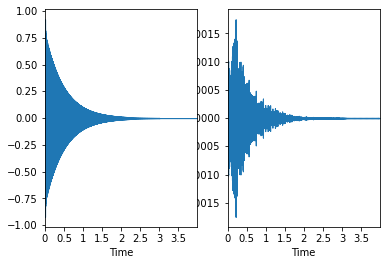

In [30]:
import IPython

decoded_array = autoencoder.predict(audio)[0]
decoded_audio = irosaspec(decoded_array,NFFT)

enprobe = rosaspec(yoriginal, NFFT)
deprobe = irosaspec(enprobe,NFFT)

noisy = yoriginal+np.random.normal(0,0.01,64000)
ennoisy = rosaspec(noisy, NFFT)
denoisy = irosaspec(ennoisy,NFFT)

import matplotlib.pyplot as plt
from librosa import display
plt.figure()
plt.subplot(1, 2, 2) 
lr.display.waveplot(y=decoded_audio,sr=sroriginal)
plt.subplot(1, 2, 1) 
lr.display.waveplot(y=yoriginal,sr=sroriginal)
plt.show()


#IPython.display.display(IPython.display.Audio(file))
IPython.display.display(IPython.display.Audio(deprobe,rate = sroriginal))
#IPython.display.display(IPython.display.Audio(deprobe,rate=sroriginal))
#IPython.display.display(IPython.display.Audio(noisy,rate=sroriginal))
#IPython.display.display(IPython.display.Audio(denoisy,rate=sroriginal))
IPython.display.display(IPython.display.Audio(decoded_audio,rate=sroriginal))





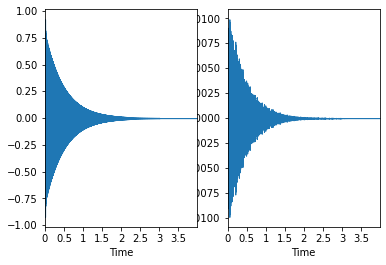

In [106]:
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Setting standard filter requirements.
order = 6
fs = 30.0       
cutoff = 14.7

b, a = butter_lowpass(cutoff, fs, order)

filtered = butter_lowpass_filter(decoded_audio, cutoff, fs, order)
plt.figure()
plt.subplot(1, 2, 2) 
lr.display.waveplot(y=filtered,sr=sroriginal)
plt.subplot(1, 2, 1) 
lr.display.waveplot(y=yoriginal,sr=sroriginal)
plt.show()

IPython.display.display(IPython.display.Audio(deprobe,rate=sroriginal))
IPython.display.display(IPython.display.Audio(filtered,rate=sroriginal))

In [102]:
audio.max(), audio.min()

(1.0, -0.856759766190995)

In [89]:
print(yoriginal.shape)
print(enprobe.shape)
print(deprobe.shape)
print(decoded_array.shape)
print(decoded_audio.shape)



(64000,)
(504, 128, 2)
(63881,)
(504, 128, 2)
(63881,)


(1.0, -0.7587283885818327)

In [81]:
i = 2
j = 4
while i<25600/2:
    NFFT = i
    file = 'C:/Users/erikv/Desktop/IP/samples/bass_electronic_027-056-050.wav'

    yoriginal,sroriginal = lr.load(file,sr=None)
    orginalspect = lr.stft(yoriginal, n_fft=NFFT, hop_length=int(NFFT/2), win_length=None, window='hann', center=False)
    audio = np.array([rosaspec(yoriginal,NFFT)])

    numbers = audio.shape
    x = numbers[1]
    y = numbers[2]
    if x%j == 0 and y%j == 0:
            print (i)
    i=i+2

110
126
134
166
174
182
254
286
294
302
334
382
406
422
478
486
494
518
526
534
582
606
630
654
670
766
782
822
846
870
894
918
942
974
1006
1038
1070
1110
1150
1190
1238
1286
1334
1342
1398
1406
1462
1470
1526
1534
1542
1606
1614


KeyboardInterrupt: 

<IPython.core.display.Javascript object>